Before launching jupyter and this notebook, type in terminal: 

``source activate nbodykit-env``

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [45]:
from nbodykit.lab import *
from nbodykit import setup_logging, style
from nbodykit.algorithms.fftpower import project_to_basis

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
plt.style.use(style.notebook)

In [3]:
setup_logging() # turn on logging to screen

# FKP norm

Let us compute the normalization of the FKP estimator. 

### Some definitions

The FKP normalization is given by:

\begin{align}\label{eq:A}
A & \equiv \int d^3 r \ \bar n(r)^2 w_{\rm FKP}(r)^2 \ , \\
\end{align}

where $\bar n(r)$ is the true mean number density in a redshift slice centered on $\chi(z) = r \cdot \hat n$, where $\chi$ is the radial comoving distance and $\hat n$ is the unit vector in the direction of the line-of-sight. 

By *true* mean number density $\bar n$ we mean the one unaffected by (non-Poissonian) observational systematics. 

##### Randoms catalog

One can estimate such density for example by creating a synthetic catalog of random objects with the same footprints on the sky of the survey and the same number density (averaged over redshift slice) as the data. 

The randoms catalog is by definition following a random uniform distribution over the sky (i.e., in angular coordinates), but where each random object is assigned a redshift randomly-selected from the data catalogs such that the randoms catalog has a mean number density that has the same redshift dependance than the data catalog. The random objects not falling within the footprints of the survey are discarded. 

Then, the *true* mean number density $\bar n$ can be estimated by averaging over redshift slices of the randoms catalog. 

##### FKP norm from window functions

One way to compute the FKP normalization is first computing the window function multipoles $Q_\ell(s)$, which can be estimated as the Fourier-transform of the power spectrum multipoles of the randoms, and then taking the $s\rightarrow 0$ limit of the monopole $Q_0(s)$: 

\begin{equation}\label{eq:As}
A_{s\rightarrow 0} = \lim_{s\rightarrow 0} \int d^3 r \ n_w(r-s) \, n_w(r) \ ,
\end{equation}
where $n_w \equiv \bar n \cdot w_{\rm FKP}$ is just a short-hand. 

##### Some more definitions (that we will not use)

Since $A$ is a $0$-mode, there are equivalent definitions that I give here for completeness but that we will not use in the following: 

\begin{align}
A_{k \rightarrow 0} & = \lim_{k\rightarrow 0} \int d^3 r \ e^{-ikr} n_w(r)^2 \\
 & = \lim_{k\rightarrow 0} \int \frac{d^3 p}{(2\pi)^3} \ \tilde n_w(p+k) \tilde n_w(p) \\
 & = \int \frac{d^3 p}{(2\pi)^3} \ \tilde n_w(p)^2 \ ,
\end{align}
where we use the convolution theorem at second line, with $\tilde n_w(p) = \int d^3 r \ e^{-ipr} n_w(r)$. 

Or, using again the convolution theorem on Eq.~\eqref{eq:As}, with $n_w(r) = \int \frac{d^3 p}{(2\pi)^3} \ e^{ipr} \tilde n_w(p)$, 
\begin{equation}
A_{s\rightarrow 0} = \lim_{s\rightarrow 0} \int d^3 p \ e^{iks} \tilde n_w(p)^2 
\end{equation}

##### FKP norm from $\bar n(z)$ estimation

Another way to compute the FKP normalization is to simply evaluate Eq.~\eqref{eq:A}. Provided an estimate for $\bar n(z)$, the FKP normalization can then be estimated as:

\begin{equation}
A_{\sum} = \sum_{i=1}^{N_r} \ \bar n (z_i) \ w_{\rm FKP,i}^2 \ ,
\end{equation}
where the sum runs over all $N_r$ objects of the randoms catalog. 

BOSS provides an estimate of $\bar n(z)$ through its catalogs. However, we find that the normalization obtained with such estimate is discrepant at $\sim 10\%$ with the value we obtain through the window functions, Eq.~\eqref{eq:As}, which tells us that the BOSS estimate of $\bar n(z)$ is not accurate enough for this purpose. 

We thus first discuss an accurate way to estimate $\bar n(z)$, which only makes use of the randoms catalog, without relying on other input. 

##### Estimating $\bar n(z)$ from the randoms

We proceed in two steps. 

First, we estimate $\bar n_{\rm tot}$ the total mean number density over the whole synthetic catalog of $N_r$ random objects. 
This provides the total volume: 

\begin{equation}
V_{\rm tot} = \frac{N_r}{\bar n_{\rm tot}} \ .
\end{equation}

To estimate $\bar n_{\rm tot}$, we put all the objects in a 3D grid with known dimensions (in comoving coordinates), and build the histogram of the (local) densities of the cells. 
Albeit taking a grid that is not too big compared to the survey, with appropriate size for the cells to contain in average a sufficient number of objects, and discarding the empty cells (tiling the regions outside the survey), the maximum of the histogram gives an estimate of the $\bar n_{\rm tot}$. 

Second, we count $N_\nu$ and calculate $V_\nu$, respectively the number of objects and volume of redshift slices $\nu = 1, 2, \dots$. 
This provides the mean number density per redshift slices:

\begin{equation}
\bar n (z_\nu) \equiv \bar n_{\nu} = \frac{N_\nu}{V_\nu} \ .
\end{equation}

To get the volume $V_\nu$, assuming that the solid angle of the survey (i.e. the angular area seen in the sky) is constant over redshift, we simply need to calculate the fractional volume $f_\nu$ of the redshift slice $\nu$ centered on $z_\nu$ with thickness $\Delta z$, and multiply it by the total volume: 

\begin{equation}
V_\nu = f_\nu \times V_{\rm tot} \ , \qquad f_\nu =  \frac{\chi(z_\nu+\Delta z/2)^3 - \chi(z_\nu-\Delta z/2)^3}{\chi(z_{\rm max})^3 - \chi(z_{\rm min})^3} \ ,
\end{equation}

where $\chi(z)$ is the comoving distance, and $z_{\rm min}, z_{\rm max}$ are respectively the minimal and maximal redshifts of the survey. 

All in all, 

\begin{equation}
\bar n (z_\nu) = \bar n_{\rm tot} \frac{N_\nu/N_r}{f_\nu} \ .
\end{equation}

Now, let's compute.

### Getting BOSS catalogs

In [4]:
def print_download_progress(count, block_size, total_size):
    import sys
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def download_data(download_dir):
    """
    Download the FITS data needed for this notebook to the specified directory.
    
    Parameters
    ----------
    download_dir : str
        the data will be downloaded to this directory
    """
    from six.moves import urllib
    import shutil
    import gzip
    
    urls = ['https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_North.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_South.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz']
    filenames = ['random0_DR12v5_CMASSLOWZTOT_North.fits', 
                 'random0_DR12v5_CMASSLOWZTOT_South.fits',
                 'galaxy_DR12v5_CMASSLOWZTOT_North.fits', 
                 'galaxy_DR12v5_CMASSLOWZTOT_South.fits']
    
    # download both files
    for i, url in enumerate(urls):
        
        # the download path
        filename = url.split('/')[-1]
        file_path = os.path.join(download_dir, filename)
        final_path = os.path.join(download_dir, filenames[i])
        
        # do not re-download
        if not os.path.exists(final_path):
            print("Downloading %s" % url)
            
            # Check if the download directory exists, otherwise create it.
            if not os.path.exists(download_dir):
                os.makedirs(download_dir)

            # Download the file from the internet.
            file_path, _ = urllib.request.urlretrieve(url=url,
                                                      filename=file_path,
                                                      reporthook=print_download_progress)

            print()
            print("Download finished. Extracting files.")

            # unzip the file
            with gzip.open(file_path, 'rb') as f_in, open(final_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            os.remove(file_path)
            print("Done.")
        else:
            print("Data has already been downloaded.")

In [5]:
# download the data to the current directory
download_dir = "catalogs"
download_data(download_dir)

Data has already been downloaded.
Data has already been downloaded.
Data has already been downloaded.
Data has already been downloaded.


### Selecting the skycut

In [6]:
red, sky = 'lowz', 'South'
if red == 'lowz': zmin, zmax = 0.20, 0.43
elif red == 'cmass': zmin, zmax = 0.43, 0.7

In [7]:
# NOTE: change this path if you downloaded the data somewhere else!
data_path = os.path.join(download_dir, 'galaxy_DR12v5_CMASSLOWZTOT_%s.fits') % sky
randoms_path = os.path.join(download_dir, 'random0_DR12v5_CMASSLOWZTOT_%s.fits') % sky

# initialize the FITS catalog objects for data and randoms
data = FITSCatalog(data_path)
randoms = FITSCatalog(randoms_path)

[ 000000.05 ]   0: 04-13 14:53  CatalogSource   INFO     Extra arguments to FileType: () {}
[ 000000.06 ]   0: 04-13 14:53  CatalogSource   INFO     Extra arguments to FileType: () {}


In [8]:
# slice the randoms
valid = (randoms['Z'] > zmin)&(randoms['Z'] < zmax)
randoms = randoms[valid]

# slice the data
valid = (data['Z'] > zmin)&(data['Z'] < zmax)
data = data[valid]

In [9]:
# the fiducial BOSS DR12 cosmology
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['RA'], data['DEC'], data['Z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['RA'], randoms['DEC'], randoms['Z'], cosmo=cosmo)

In [10]:
randoms['WEIGHT'] = 1.0
data['WEIGHT'] = data['WEIGHT_SYSTOT'] * (data['WEIGHT_NOZ'] + data['WEIGHT_CP'] - 1.0)

Here we define 
\begin{equation}
\alpha = \frac{N_d}{N_r} \ ,
\end{equation}
and
\begin{equation}
\alpha_w = \frac{\sum_i^{N_d} w_i}{\sum_i^{N_r} w_i} \ .
\end{equation}

In [59]:
Nd, Nr = data.csize, randoms.csize
alpha = Nd / Nr
alpha_w = np.sum(data['WEIGHT'].compute()) / np.sum(randoms['WEIGHT'].compute())
print ('alpha = %.5f' % alpha)

alpha = 0.02040


### Estimating $\bar n_{\rm tot}$

Let us put the randoms on a 3D grid

In [12]:
fkp = FKPCatalog(randoms, None) 

In [13]:
Nmesh = 64
mesh = fkp.to_mesh(Nmesh=Nmesh, fkp_weight='WEIGHT', # we don't want to put any FKP weight here
                   comp_weight='WEIGHT', resampler='NEAREST', interlaced=False)

[ 000103.98 ]   0: 04-13 14:54  FKPCatalog      INFO     cartesian coordinate range: [ 396.53308858 -787.14611995 -219.7633999 ] : [1154.57389049  815.35405014  680.71090682]
[ 000103.98 ]   0: 04-13 14:54  FKPCatalog      INFO     BoxSize = [ 774. 1635.  919.]
[ 000103.98 ]   0: 04-13 14:54  FKPCatalog      INFO     BoxCenter = [775.55348954  14.10396509 230.47375346]


In [14]:
w = mesh.to_real_field() 

/Users/pierre/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/algorithms/convpower/catalogmesh.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  attrs['alpha'] = attrs['data.W'] / attrs['randoms.W']
[ 000117.73 ]   0: 04-13 14:55  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 5422423 
[ 000132.54 ]   0: 04-13 14:55  CatalogMesh     INFO     painted 4194304 out of 5422423 objects to mesh
[ 000132.54 ]   0: 04-13 14:55  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 5422423 
[ 000136.75 ]   0: 04-13 14:55  CatalogMesh     INFO     painted 5422423 out of 5422423 objects to mesh
[ 000136.76 ]   0: 04-13 14:55  CatalogMesh     INFO     painted 5422423 out of 5422423 objects to mesh
[ 000136.76 ]   0: 04-13 14:55  CatalogMesh     INFO     mean particles per cell is 20.6849
/Users/pierre/.conda/envs/nbodykit-env/lib/python3.8/logging/__init__.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
[ 00013

Get the (local) densities of the cells

In [15]:
Vbox = np.prod(w.pm.BoxSize)
Vcell = Vbox / Nmesh**3 
print ('Vcell = %.1f' % Vcell)
Ngrid = np.real( w.preview().reshape(-1) ) * Vcell
print ('Check if all objects are put on the grid: %s'  % (np.sum(Ngrid) / randoms.csize) )
nloc = Ngrid / Vcell

Vcell = 4436.4
Check if all objects are put on the grid: 1.0


remove 0's

In [16]:
nloc = nloc[nloc != 0.]

plot histogram

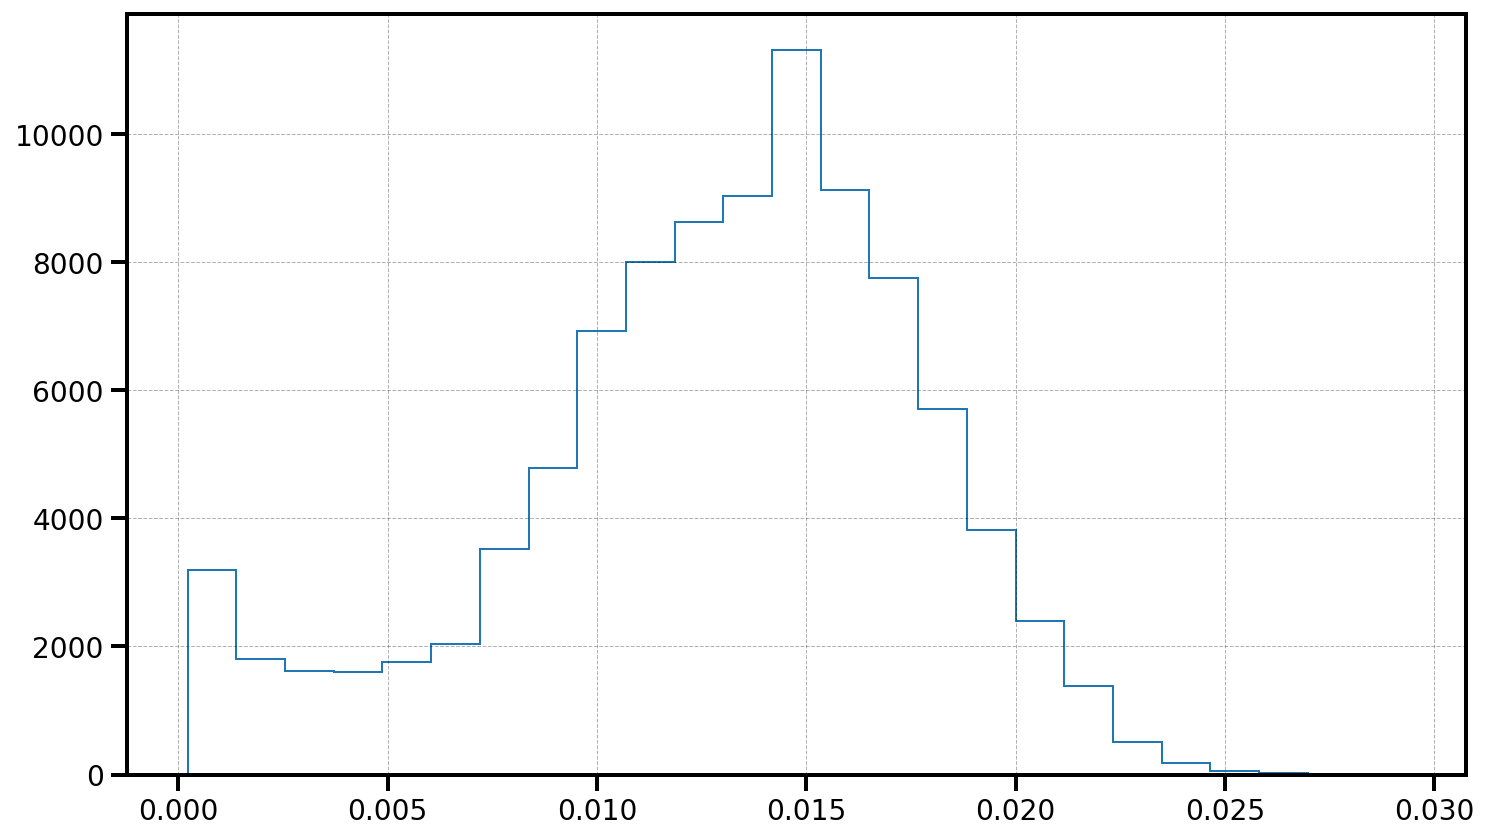

In [17]:
counts, bins = np.histogram(nloc, bins=25)
plt.stairs(counts, bins)
plt.show()

There is a fatter tail on the left since the cells on the edges will be half-empty. 

Finding the maximum of the histogram (which we take to be the central value of the bin where there is the maximum)

In [68]:
ntot = 0.5*( bins[np.argmax(counts)] + bins[np.argmax(counts)+1] )

In [86]:
rel_err_dist = np.std(nloc) / ntot
rel_err_pois = Nr**-.5 / ntot
print ('distribution standard deviation: %.2f | Poisson uncertainty: %.2f' % (rel_err_dist, rel_err_pois))

distribution standard deviation: 0.33 | Poisson uncertainty: 0.03


In [98]:
print ('total mean number density (rescaled to data): %.4e [Mpc/h]^3' % (alpha_w*ntot))

total mean number density (rescaled to data): 3.1297e-04 [Mpc/h]^3


### Estimating the fractional volume $f_\nu$ of redshift slices $\nu$

Defining the redshift slices

In [21]:
dz = 0.01
zz = np.arange(zmin+dz/2., zmax+1.e-9, dz)

Counting the number of random objects $N_\nu$ in redshift slice $\nu$

In [26]:
Nz = np.zeros_like(zz)
nz_boss = np.zeros_like(zz) # for comparison

for i, z in enumerate(zz):
    print ('%s, %.3f' % (i, z))
    valid = (randoms['Z'] > z-dz/2.) & (randoms['Z'] < z+dz/2.)
    randoms_z = randoms[valid]
    Nz[i] = randoms_z.csize
    nz_boss[i] = np.sum(randoms_z['NZ'].compute()) / Nz[i]

0, 0.205
1, 0.215
2, 0.225
3, 0.235
4, 0.245
5, 0.255
6, 0.265
7, 0.275
8, 0.285
9, 0.295
10, 0.305
11, 0.315
12, 0.325
13, 0.335
14, 0.345
15, 0.355
16, 0.365
17, 0.375
18, 0.385
19, 0.395
20, 0.405
21, 0.415
22, 0.425


Fractional volume $f_\nu$

In [28]:
def comoving_distance(z): # Mpc/h
    c, Omega_m = 3.e5, 0.310
    zz = np.linspace(0, z, 100, endpoint=True)
    return c/100. * np.trapz((1-Omega_m + Omega_m * (1+zz)**3)**-.5, x=zz) 

def volume(z1, z2): # not the volume per se, just the part that we need
    return comoving_distance(z2)**3-comoving_distance(z1)**3

Vtot = volume(zmin, zmax)
Vz = np.array([volume(zz[i]-dz/2., zz[i]+dz/2.) for i in range(len(zz))])

fVz = Vz / Vtot

### All in all

\begin{equation}
\bar n (z_\nu) = \bar n_{\rm tot} \frac{N_\nu/N_r}{f_\nu} \ .
\end{equation}

In [48]:
nz = ntot * Nz / Nr / fVz

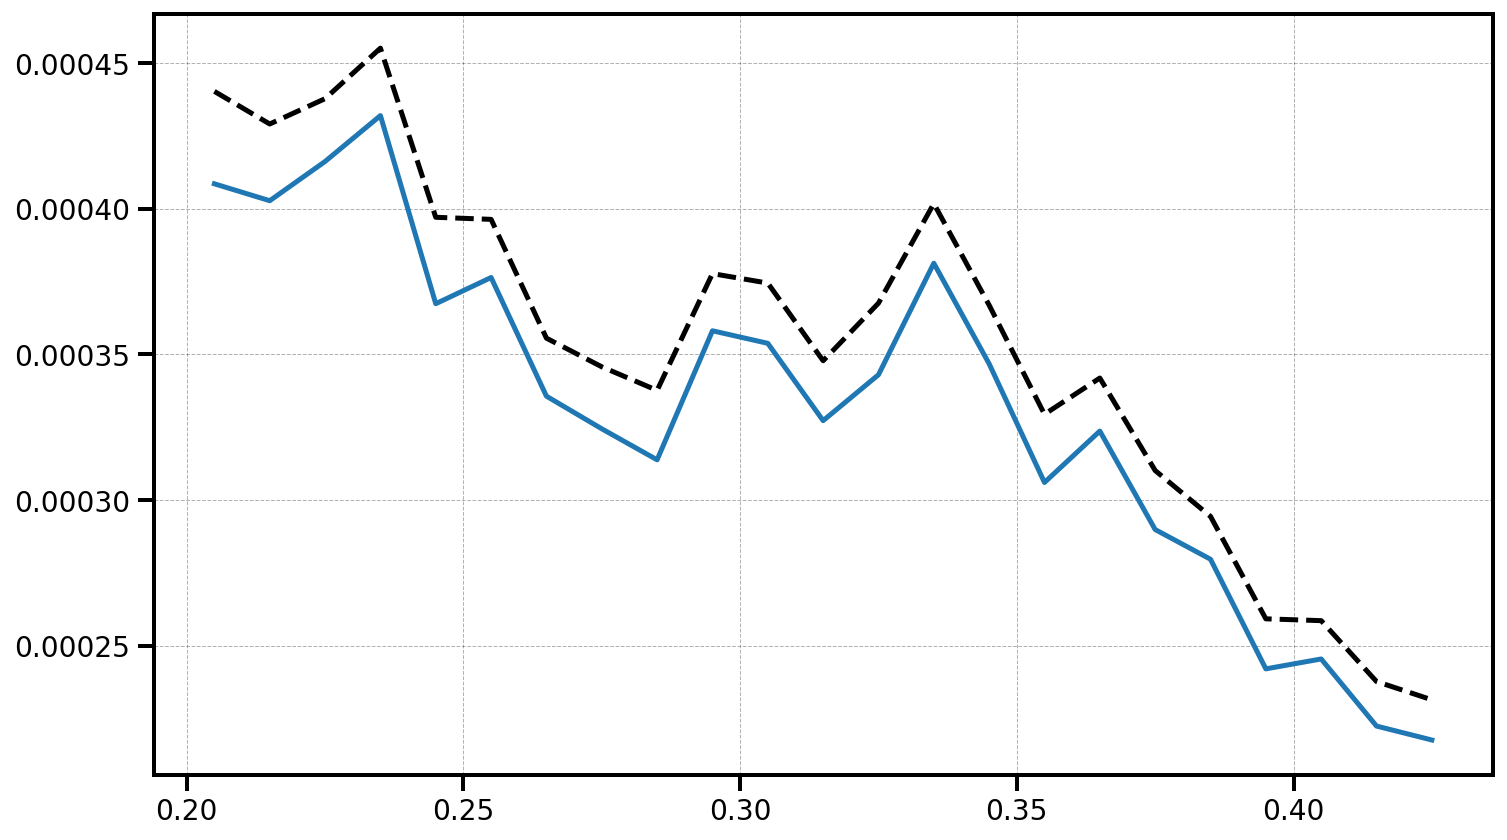

In [97]:
plt.plot(zz, alpha_w * nz)
plt.plot(zz, nz_boss, 'k--')

### Computing the normalization $A_\sum$

In [46]:
z_cat, nz_boss_cat, wfkp_cat = randoms['Z'].compute(), randoms['NZ'].compute(), randoms['WEIGHT_FKP']

In [95]:
nz_cat = interp1d(zz, alpha_w * nz, bounds_error=False, fill_value=(alpha_w * nz[0], alpha_w * nz[-1]))(z_cat)

In [96]:
A_sum = alpha_w * np.sum(nz_cat * wfkp_cat**2) 
A_boss = alpha_w * np.sum(nz_boss_cat * wfkp_cat**2)
print ('A_sum = %.3e, A_boss = %.3e, A_sum/A_boss = %.3f +\- %.3f' % (A_sum, A_boss, A_sum/A_boss, rel_err_pois))

A_sum = 1.904e+00, A_boss = 2.020e+00, A_sum/A_boss = 0.942 +\- 0.029


Here are the ratios $A_{s\rightarrow 0} / A_{\rm BOSS}$: 

norm sgc lowz: 0.922, (quad: 0.922)   
norm ngc lowz: 0.925, (quad: 0.925)  
norm sgc cmass: 0.929, (quad: 0.929)  
norm ngc cmass: 0.929, (quad: 0.923)  